#Conformal Predictions with e-value

In [1]:
%matplotlib inline
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

tf.random.set_seed(2024)

TensorFlow version: 2.15.0


## Examples with MNIST

## Load a dataset

Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). The pixel values of the images range from 0 through 255. Scale these values to a range of 0 to 1 by dividing the values by `255.0`. This also converts the sample data from integers to floating-point numbers:

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

Let us view some examples:

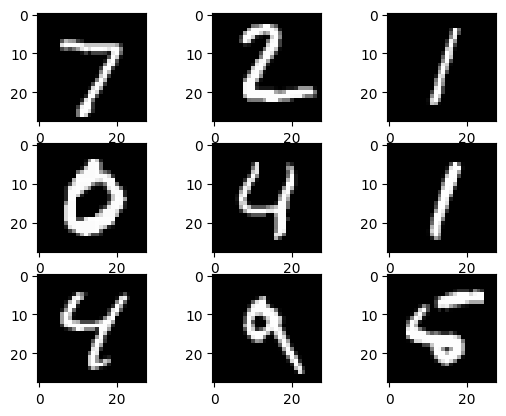

In [3]:
from matplotlib import pyplot
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(x_test[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

## Build a deep learning machine learning model

Build a `tf.keras.Sequential` model:

In [4]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

For each example, the model returns a vector of [logits](https://developers.google.com/machine-learning/glossary#logits) or [log-odds](https://developers.google.com/machine-learning/glossary#log-odds) scores, one for each class.

In [5]:
predictions = model(x_train[:1]).numpy()
predictions

array([[-0.22065288,  0.03057644,  0.04112254,  0.16367292, -0.49228632,
        -0.3727892 , -0.46313775, -0.68624234,  0.5098478 , -0.10292819]],
      dtype=float32)

The `tf.nn.softmax` function converts these logits to *probabilities* for each class:

In [6]:
tf.nn.softmax(predictions).numpy()

array([[0.08858994, 0.11389166, 0.11509912, 0.1301053 , 0.06751738,
        0.07608735, 0.06951437, 0.05561366, 0.18392333, 0.09965787]],
      dtype=float32)

Note: It is possible to bake the `tf.nn.softmax` function into the activation function for the last layer of the network. While this can make the model output more directly interpretable, this approach is discouraged as it's impossible to provide an exact and numerically stable loss calculation for all models when using a softmax output.
<br><br>

Define a loss function for training using `losses.SparseCategoricalCrossentropy`:



In [7]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

The loss function takes a vector of ground truth values and a vector of logits and returns a scalar loss for each example. This loss is equal to the negative log probability of the true class: The loss is zero if the model is sure of the correct class.

This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to `-tf.math.log(1/10) ~= 2.3`.

In [8]:
loss_fn(y_train[:1], predictions).numpy()

2.5758734

Before you start training, configure and compile the model using Keras `Model.compile`. Set the [`optimizer`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) class to `adam`, set the `loss` to the `loss_fn` function you defined earlier, and specify a metric to be evaluated for the model by setting the `metrics` parameter to `accuracy`.

In [9]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

## Train and evaluate your model

Use the `Model.fit` method to adjust your model parameters and minimize the loss:

In [10]:
model.fit(x_train, y_train, epochs=25)

Epoch 1/25
1875/1875 [==============================] - 17s 6ms/step - loss: 0.2983 - accuracy: 0.9133
Epoch 2/25
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1432 - accuracy: 0.9574
Epoch 3/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1074 - accuracy: 0.9673
Epoch 4/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0881 - accuracy: 0.9732
Epoch 5/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0757 - accuracy: 0.9757
Epoch 6/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0662 - accuracy: 0.9785
Epoch 7/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0603 - accuracy: 0.9807
Epoch 8/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0532 - accuracy: 0.9824
Epoch 9/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0484 - accuracy: 0.9841
Epoch 10/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0

The `Model.evaluate` method checks the model's performance, usually on a [validation set](https://developers.google.com/machine-learning/glossary#validation-set) or [test set](https://developers.google.com/machine-learning/glossary#test-set).

In [11]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.0787 - accuracy: 0.9820 - 741ms/epoch - 2ms/step


[0.07869688421487808, 0.9819999933242798]

The image classifier is now trained to ~98% accuracy on this dataset.

If you want your model to return a probability, you can wrap the trained model, and attach the softmax to it:

In [12]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [13]:
probability_model(x_test[:2])

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[1.11150103e-10, 6.45277221e-14, 2.35665518e-13, 2.88017446e-07,
        2.21573203e-20, 2.65465530e-14, 4.81740366e-22, 9.99999762e-01,
        1.10966875e-10, 1.19279306e-08],
       [1.00456308e-15, 5.78893741e-06, 9.99994159e-01, 3.02276948e-13,
        1.09235751e-31, 5.76975316e-13, 3.90476327e-20, 1.16692838e-30,
        4.07226987e-13, 2.10300712e-22]], dtype=float32)>

Let us see examples from the test set with wrong predictions

In [14]:
predictions_on_tests = np.argmax(probability_model(x_test), axis=1)
predictions_on_tests

array([7, 2, 1, ..., 4, 5, 6])

In [15]:
sum(predictions_on_tests != y_test)

180

In [16]:
wrong_predictions = x_test[predictions_on_tests != y_test]
wrong_predictions.shape

(180, 28, 28)

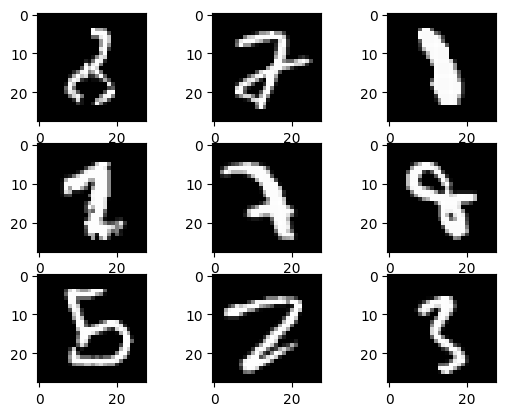

In [17]:
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(wrong_predictions[i+9], cmap=pyplot.get_cmap('gray'))
pyplot.show()

<br><br>

### MNIST and Inductive CP with simple loss function
--------------

So, we trained our model on the training data, and now let us forget about the training data.

We devide test data into two parts: `x_calibrate_cp` and `x_test_cp`,
 with corresponding labels `y_calibrate_cp` and `y_test_cp`

In [18]:
from sklearn.model_selection import train_test_split



x_calibrate_cp, x_test_cp, y_calibrate_cp , y_test_cp = train_test_split(x_test, y_test,
                                                    test_size=0.5,
                                                    random_state=0,
                                                    shuffle=True,
                                                    stratify=y_test)

Let us look into performance of our model on `x_calibrate_cp, x_test_cp`:

In [19]:
model.evaluate(x_test_cp,  y_test_cp, verbose=2)

157/157 - 0s - loss: 0.0827 - accuracy: 0.9820 - 313ms/epoch - 2ms/step


[0.08266749233007431, 0.9819999933242798]

In [20]:
model.evaluate(x_calibrate_cp,  y_calibrate_cp, verbose=2)

157/157 - 0s - loss: 0.0747 - accuracy: 0.9820 - 332ms/epoch - 2ms/step


[0.07472628355026245, 0.9819999933242798]


<br>
The non-conformity scores for `x_calibrate_cp` can be calculated in advance by using the loss function:
<br>

In [21]:
# alpha scores for calibrating set

A_calibrate = -tf.math.log(probability_model(x_calibrate_cp)).numpy()
alpha_calibrate = np.array([A_calibrate[i, y_calibrate_cp[i]] for i in range(len(y_calibrate_cp))])


In [22]:
alpha_calibrate

array([ 6.4136657e-05, -0.0000000e+00,  1.1920930e-07, ...,
       -0.0000000e+00,  1.1920930e-07,  3.2479404e-03], dtype=float32)

In [23]:
#y_calibrate_cp_predictions= np.argmin(A_calibrate, axis =1)
#sum(y_calibrate_cp != y_calibrate_cp_predictions)

#alpha_calibrate = np.min(A_calibrate, axis =1)
#alpha_calibrate.max()

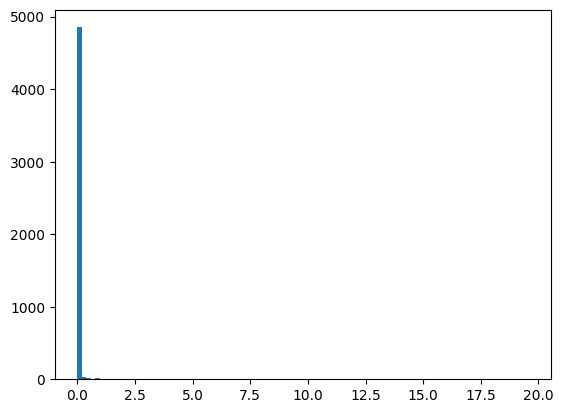

In [24]:
import matplotlib.pyplot as plt
plt.hist(alpha_calibrate, bins = 100)
plt.show()

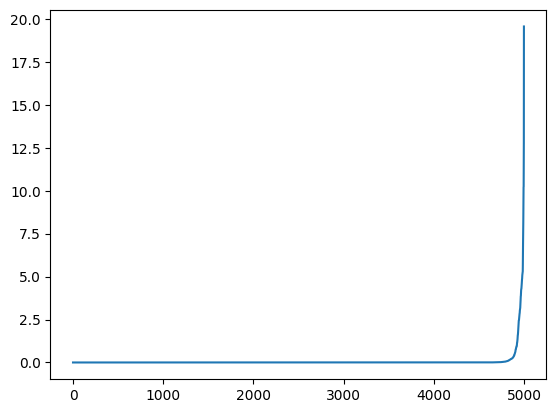

In [25]:
plt.plot(range(len(alpha_calibrate)), np.sort(alpha_calibrate))

In [26]:
nc = len(alpha_calibrate)
nc

5000

In [27]:
alpha = 0.05
l_calibrate = 1/alpha * (1/(1+ (1-1/alpha)/nc)) * alpha_calibrate.mean()


l_calibrate

1.5002265318261887

In [28]:
alpha_calibrate.mean()

0.07472628

In [29]:
np.sort(alpha_calibrate)[4937]

2.038992

## Epsilon = 0.05

We have 5000 elements in the callibrating set, so if we want $\epsilon = 0.05$, we need to calculate 4937 element in ordered list of `np.sort(alpha_calibrate)`

In [30]:
thresh = l_calibrate #np.sort(alpha_calibrate)[4937]
thresh

1.5002265318261887

In [31]:
#Probability for this threshold is
tf.math.exp(-thresh).numpy()

0.22307961979048954

In [32]:
A_test_cp = -tf.math.log(probability_model(x_test_cp)).numpy()

In [33]:
A_test_cp < thresh

array([[False, False,  True, ..., False, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [34]:
list_cp0 = [i for i in range(len(y_test_cp)) if np.sum(A_test_cp < thresh, axis =1)[i] == 0]
list_cp1 = [i for i in range(len(y_test_cp)) if np.sum(A_test_cp < thresh, axis =1)[i] == 1]
list_cp2 = [i for i in range(len(y_test_cp)) if np.sum(A_test_cp < thresh, axis =1)[i] > 1]

In [35]:
print("Examples without labels:  ",len(list_cp0))
print("Examples with one  label:  ",len(list_cp1))
print("Examples with more than one  label:  ",len(list_cp2))

Examples without labels:   0
Examples with one  label:   4944
Examples with more than one  label:   56


### Examples with labels

Let us see some examples of handwritten digits that cant have reliable labels:

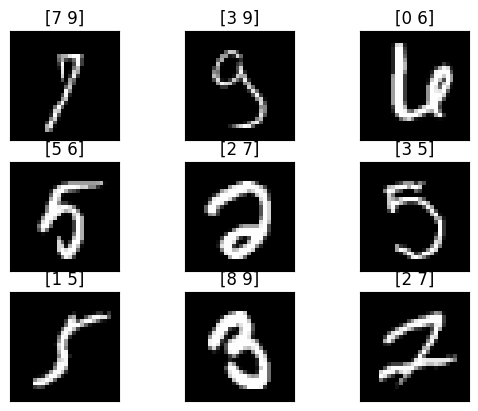

In [36]:
for i in range(9):
  ax1 = pyplot.subplot(330 + 1 + i)
  ll = ",".join(str(x) for x in np.where((A_test_cp[list_cp2[i]] < thresh)))
  ax1.title.set_text(ll)
  ax1.set_xticks([])
  ax1.set_yticks([])
  pyplot.imshow(x_test_cp[list_cp2[i]], cmap=pyplot.get_cmap('gray'))
  # print(list_cp2[i], np.where(A_test_cp[list_cp2[i]] < thresh))


pyplot.show()

## CP with standart P value

We have 5000 elements in the callibrating set, so if we want $\epsilon = 0.05$, we need to calculate 4750 element in ordered list of `np.sort(alpha_calibrate)`

In [37]:
thresh = np.sort(alpha_calibrate)[4749]
thresh

0.024706885

In [38]:
#Probability for this threshold is
tf.math.exp(-thresh).numpy()

0.97559583

In [39]:
A_test_cp = -tf.math.log(probability_model(x_test_cp)).numpy()

In [40]:
A_test_cp < thresh

array([[False, False,  True, ..., False, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [41]:
list_cp0 = [i for i in range(len(y_test_cp)) if np.sum(A_test_cp < thresh, axis =1)[i] == 0]
list_cp1 = [i for i in range(len(y_test_cp)) if np.sum(A_test_cp < thresh, axis =1)[i] == 1]
list_cp2 = [i for i in range(len(y_test_cp)) if np.sum(A_test_cp < thresh, axis =1)[i] > 1]

In [42]:
print("Examples without labels:  ",len(list_cp0))
print("Examples with one  label:  ",len(list_cp1))
print("Examples with more than one  label:  ",len(list_cp2))

Examples without labels:   238
Examples with one  label:   4762
Examples with more than one  label:   0


### Examples without labels

Let us see some examples of handwritten digits that cant have reliable labels:

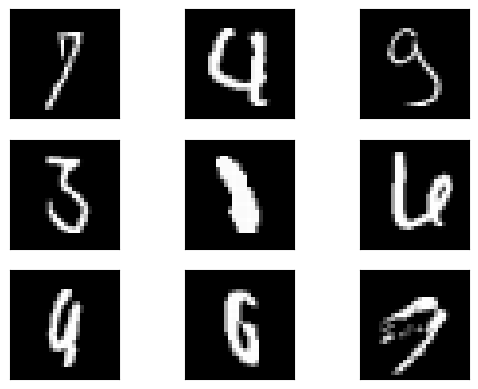

In [43]:
for i in range(9):
  ax1 = pyplot.subplot(330 + 1 + i)
  ax1.set_xticks([])
  ax1.set_yticks([])
  pyplot.imshow(x_test_cp[list_cp0[i]], cmap=pyplot.get_cmap('gray'))
pyplot.show()

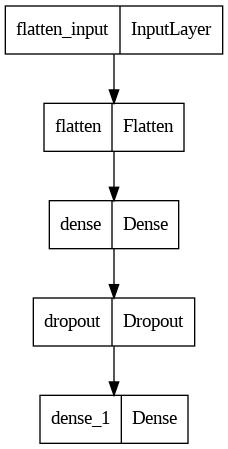

In [44]:
from tensorflow import keras
keras.utils.plot_model(model, 'my_first_model_1.png')